In [3]:
import numpy as np
import h5py
from scipy.interpolate import interp1d
from matplotlib.pyplot import *
import scipy.stats as stats
%matplotlib notebook

In [9]:
def batched_minimal_rms_difference(X,Y):
    """
    args:
    X: a shot number x pixels array
    Y: a shot number x pixels array
    returns X_scaled such that it minimizes the least squares difference between
    X and Y on a shot-by-shot basis.
    """
    Xstd = X.std(axis=0).mean()
    Ystd = Y.std(axis=0).mean()
    Xs = X/Xstd
    Ys = Y/Ystd
    xaug = np.stack([Xs,np.ones_like(X)],-1)   # BxNx2
    xaug_pinv = np.linalg.pinv(xaug)  # Bx2xN
    z = xaug_pinv @ Ys[:,:,None]  # Bx2xN @ BxNx1 -> Bx2x1
    return np.sqrt(np.mean((np.squeeze(xaug @ z,-1) - Ys)**2,axis=-1))

def preprocess_run(run_num, std_diff_max = 2):
    with h5py.File(f'/reg/d/psdm/cxi/cxix46119/hdf5/smalldata/data/cxix46119_r{run_num}.h5','r') as f:
        epix_axis = np.array(f['epix_axis'])
        xrt_axis = np.array(f['xrt_axis'])
        zpos = np.array(f['zpos_and_timestamps'])
        xrt_spectra = np.array(f['xrt_spectra'])
        epix_spectra = np.array(f['epix_spectra'])
    # remove times where the motor PV RBV is zero
    zpf = zpos[:,0]<0
    xrt_spectra_filtered = xrt_spectra[zpf,:]
    epix_spectra_filtered = epix_spectra[zpf,:]
    zpos_filtered = zpos[zpf,0]
    # remove spectra with nans
    xrt_nans = np.any(np.isnan(xrt_spectra_filtered),axis=-1)
    epix_nans = np.any(np.isnan(epix_spectra_filtered),axis=-1)
    nan_filter = np.logical_not(np.logical_or(xrt_nans, epix_nans))
    xrt_spectra_filtered = xrt_spectra_filtered[nan_filter,:]
    epix_spectra_filtered = epix_spectra_filtered[nan_filter,:]
    zpos_filtered = zpos_filtered[nan_filter]
    rms_diff = batched_minimal_rms_difference(xrt_spectra_filtered, epix_spectra_filtered)
    diff_filter = rms_diff<std_diff_max
    xrt_spectra_filtered = xrt_spectra_filtered[diff_filter,:]
    epix_spectra_filtered = epix_spectra_filtered[diff_filter,:]
    zpos_filtered = zpos_filtered[diff_filter]
    zpos_steps = np.unique(np.round(zpos_filtered,3))
    xrt_specs_stepped = []
    epix_specs_stepped = []
    for z in zpos_steps:
        mask = np.round(zpos_filtered,3) == z
        xrt_specs_stepped.append(xrt_spectra_filtered[mask,:])
        epix_specs_stepped.append(epix_spectra_filtered[mask,:])
    return xrt_specs_stepped, epix_specs_stepped, zpos_steps, epix_axis

def merge_runs(runs, std_diff_max = 2):
    xs = []
    es = []
    for k,run in enumerate(runs):
        if k==0:
            xsl, esl, zs0, eaxis0 = preprocess_run(run, std_diff_max = std_diff_max)
            xs.append([np.copy(x) for x in xsl])
            es.append([np.copy(e) for e in esl])
            z = zs0
        else:
            xsl, esl, zsl, eaxisl = preprocess_run(run, std_diff_max = std_diff_max)
            if np.all(zsl == z) and np.all(eaxisl == eaxis0):
                print(f'merged run {run}')
                xs.append([np.copy(x) for x in xsl])
                es.append([np.copy(e) for e in esl])
            else:
                print(f'could not merge run {run}')
    xs = np.array(xs,dtype=object).T.tolist()
    es = np.array(es,dtype=object).T.tolist()
    return [np.concatenate(x,0) for x in xs], [np.concatenate(e,0) for e in es], z, eaxis0

def optimal_spearman_offset(xspearman,search_min=-20,search_max=20,roi_min=20,roi_max=80):
    diags = []
    for k in range(search_min,search_max):
        diags.append(np.diag(xspearman,k=k)[roi_min:roi_max].sum())
    diags = np.array(diags)
    nan_filter = np.logical_not(np.isnan(diags))
    opt_ind = np.argmax(diags[nan_filter])
    ks = np.arange(search_min,search_max)[nan_filter]
    return ks[opt_ind]

def spearman_spectrum(xrt_specs, epix_specs, axis, offset_search_min=None,offset_search_max=None,roi_min=None,roi_max=None):
    spearmanr = stats.spearmanr(xrt_specs,epix_specs)[0]
    L = spearmanr.shape[0]
    cross_spearman = spearmanr[L//2:,:L//2]
    if offset_search_max is None:
        offset_search_max = L//4-1
    if offset_search_min is None:
        offset_search_min = -L//4+1
    if roi_min is None or roi_max is None:
        roi_mask = cross_spearman.max(axis=0)>0.6
        roi_axis = np.arange(cross_spearman.shape[0])
        roi_midpoint = int(np.mean(roi_axis[roi_mask]))
        roi_width = int(np.std(roi_axis[roi_mask]))
        roi_min = np.clip(roi_midpoint - roi_width,a_min=0,a_max=cross_spearman.shape[0])
        roi_max = np.clip(roi_midpoint + roi_width,a_min=roi_min,a_max=cross_spearman.shape[0])
    kopt = optimal_spearman_offset(cross_spearman,search_min=offset_search_min,
                                  search_max=offset_search_max,
                                  roi_min=roi_min,
                                  roi_max=roi_max)
    print('optimal offset was: ', kopt)
    if kopt>0:
        axis_adj = axis[kopt:]
    elif kopt<0:
        axis_adj = axis[:kopt]
    spec = np.diag(cross_spearman,k=kopt)
    return spec, axis_adj

def spearman_img(xrt_specs, epix_specs, offset_search_min=None,offset_search_max=None,roi_min=20,roi_max=80):
    spearmanr = stats.spearmanr(xrt_specs,epix_specs)[0]
    L = spearmanr.shape[0]
    cross_spearman = spearmanr[L//2:,:L//2]
    if offset_search_max is None:
        offset_search_max = L//4-1
    if offset_search_min is None:
        offset_search_min = -L//4+1
    kopt = optimal_spearman_offset(cross_spearman,search_min=offset_search_min,
                                  search_max=offset_search_max,
                                  roi_min=roi_min,
                                  roi_max=roi_max)
    print('optimal offset was: ', kopt)
    return cross_spearman

In [10]:
xrt_specs_stepped,epix_specs_stepped, zpos_steps, epix_axis = merge_runs(list(range(216,225)))

merged run 217
merged run 218
merged run 219
merged run 220
merged run 221
merged run 222
merged run 223
merged run 224


<IPython.core.display.Javascript object>


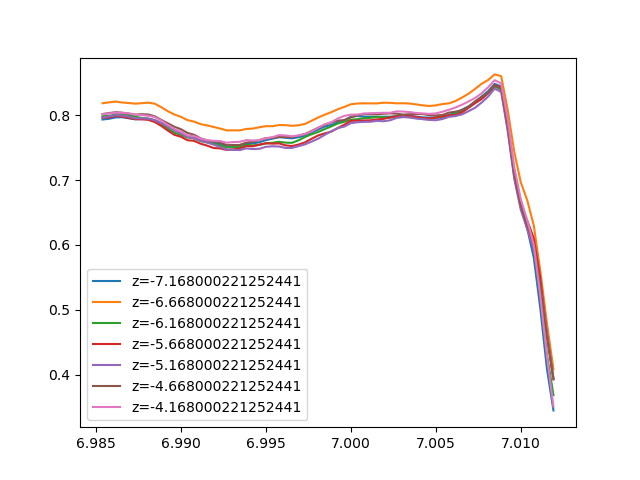

optimal offset was:  -31


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


optimal offset was:  -31


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


optimal offset was:  -31


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


optimal offset was:  -31


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


optimal offset was:  -31


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


optimal offset was:  -31
optimal offset was:  -31


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [11]:
figure()
for xspec, espec, z in zip(xrt_specs_stepped,epix_specs_stepped, zpos_steps):
    spec, axis = spearman_spectrum(xspec, espec, epix_axis);
    plot(axis, spec, label=f"z={z}")
legend()

In [12]:
xrt_specs_stepped2, epix_specs_stepped2, zpos_steps2, epix_axis2 = merge_runs(list(range(202,206)))

merged run 203
merged run 204
merged run 205


<IPython.core.display.Javascript object>


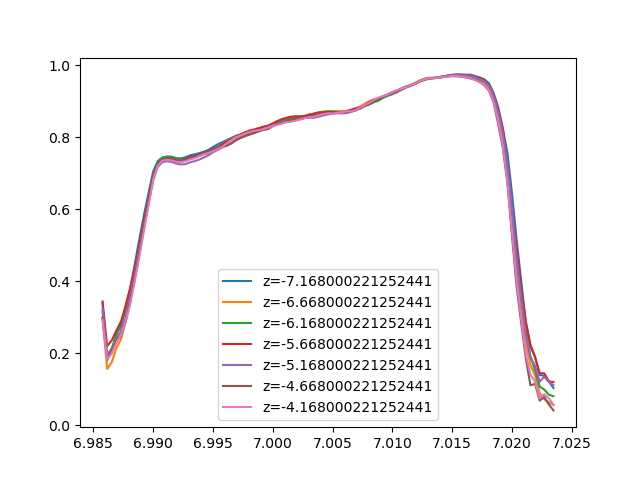

/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


optimal offset was:  1


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


optimal offset was:  1


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


optimal offset was:  1


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


optimal offset was:  1


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


optimal offset was:  1


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


optimal offset was:  1
optimal offset was:  1


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.22-py3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [13]:
figure()
for xspec, espec, z in zip(xrt_specs_stepped2, epix_specs_stepped2, zpos_steps2):
    spec, axis = spearman_spectrum(xspec, espec, epix_axis2);
    plot(axis, spec, label=f"z={z}")
legend()